# CHAPTER 07 머신러닝을 이용한 광물자원탐사 융합해석

## 1. 광체 모델링

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [2]:
training_data = pd.read_csv('Data/drill_data.csv')

# 데이터 시각화

seaborn 라이브러리를 이용하여 데이터 특성간 그리고 레이블의 상관성을 시각화하였다. 그림에서 볼 수 있듯이 resistivity와 density의 특성만으로도 광체와 비광체의 분리가 가능한 것을 확인할 수 있다.

In [4]:
ores_colors = ['#FF0000', '#0000FF']

ores_labels = ['NotOre', 'Ore']

ores_color_map = {}
for ind, label in enumerate(ores_labels):
    ores_color_map[label] = ores_colors[ind]

def label_ores(row, labels):
    return labels[int(row['Ore_log'])]
    
training_data.loc[:,'OreLabels'] = training_data.apply(lambda row: label_ores(row, ores_labels), axis=1)

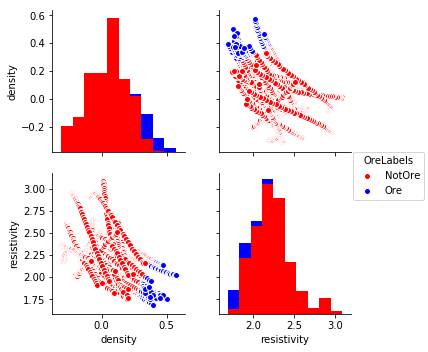

In [5]:
import seaborn as sns
sns.pairplot(training_data.drop(['X','Y', 'Z', 'Ore_log'], axis=1), hue="OreLabels", palette=ores_color_map, hue_order=list(ores_labels))

# 훈련/검증 데이터세트 나누기

훈련/검증 데이터세트에서 광체 레이블의 비율을 일정하게 하기 위해 계층적 샘플링(stratified sampling)을 수행하였다. 

In [6]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(training_data, test_size=0.2, stratify=training_data['Ore_log'],
                                      random_state=0)

아래의 코드로 광체의 비율이 적절하게 나누어진 것을 확인할 수 있다

In [7]:
train_set["Ore_log"].value_counts() / len(train_set)

0    0.917857
1    0.082143
Name: Ore_log, dtype: float64

In [8]:
val_set["Ore_log"].value_counts() / len(val_set)

0    0.917143
1    0.082857
Name: Ore_log, dtype: float64

# 훈련/검증 세트에서 입력과 레이블 분리

In [9]:
X_train, y_train = train_set[['density', 'resistivity']].values, train_set[['Ore_log']].values.ravel()
X_val, y_val = val_set[['density', 'resistivity']].values, val_set[['Ore_log']].values.ravel()

# 모델 훈련하고 검증하기

데이터가 단순하고 쉽게 분리가 가능하므로 신경망을 제외한 결정 트리, 랜덤 포레스트, 그레디언트 부스팅, 로지스틱 회귀, 서포트 벡터 머신 모델을 훈련하였고, 검증 데이터로 정확도를 확인하였다 <br>
단 로지스틱 회귀, 서포트 벡터 머신 모델을 스케일에 민감하므로 standard 스케일링을 적용하여 파이프라인을 구성하였다. 

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score


tree_clf = DecisionTreeClassifier(max_depth=3, random_state=10)

rnd_clf = RandomForestClassifier(n_estimators=10,max_depth=8, random_state=10)

gbst_clf = GradientBoostingClassifier(n_estimators=400,max_depth=1, random_state=10)

lgst_clf = Pipeline([
        ("Poly", PolynomialFeatures(degree=6)),
        ("scaler", StandardScaler()),
        ("lgst", LogisticRegression(C=100))
    ])

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", gamma=0.01, C=1000, probability=True))
    ])

for clf in (tree_clf, rnd_clf, gbst_clf, lgst_clf, svm_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    if clf.__class__.__name__ is 'Pipeline':
        print(clf.steps[-1][-1].__class__.__name__, accuracy_score(y_val, y_pred))
    else:
        print(clf.__class__.__name__, accuracy_score(y_val, y_pred))
        

DecisionTreeClassifier 0.9828571428571429
RandomForestClassifier 0.9885714285714285
GradientBoostingClassifier 0.9857142857142858
LogisticRegression 0.9914285714285714
SVC 0.9942857142857143


검증 결과에서 볼 수 있듯이 서포트 벡터 머신의 검증 정확도가 가장 높게 나온다

# 결정 경계(decision boundary) 시각화

최종 모델을 선택하기 위해 훈련된 모델들의 결정 경계를 확인하였다

In [11]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 1000)
    x1s = np.linspace(axes[2], axes[3], 1000)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]    
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel("density", fontsize=14)
    plt.ylabel("resistivity", fontsize=14)

Text(0.5,1,'Decision Tree')

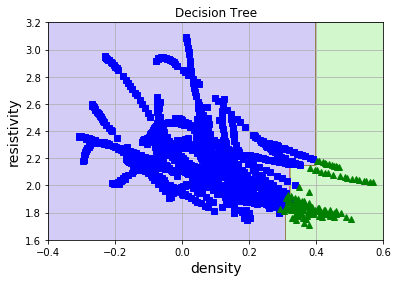

In [12]:
plot_dataset(X_train, y_train, [-0.4, 0.6, 1.6, 3.2])
plot_predictions(tree_clf, [-0.4, 0.6, 1.6, 3.2])
plt.title('Decision Tree')

Text(0.5,1,'Random Forest')

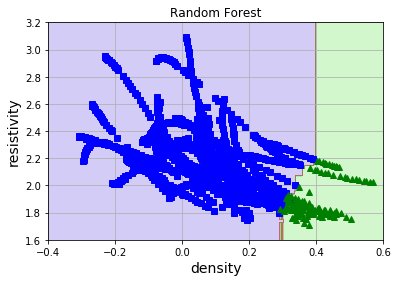

In [13]:
plot_dataset(X_train, y_train, [-0.4, 0.6, 1.6, 3.2])
plot_predictions(rnd_clf, [-0.4, 0.6, 1.6, 3.2])
plt.title('Random Forest')

Text(0.5,1,'Gradient Boost')

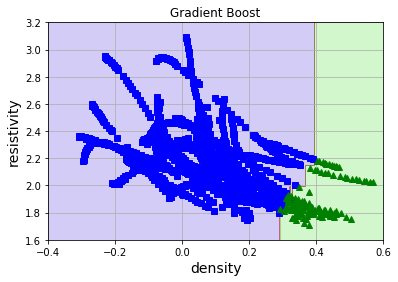

In [14]:
plot_dataset(X_train, y_train, [-0.4, 0.6, 1.6, 3.2])
plot_predictions(gbst_clf, [-0.4, 0.6, 1.6, 3.2])
plt.title('Gradient Boost')

Text(0.5,1,'Logistic Regression')

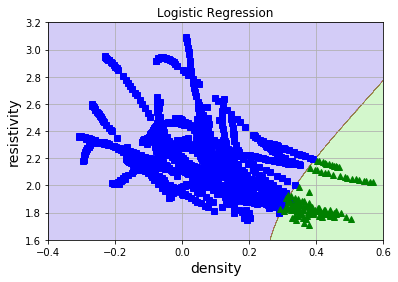

In [15]:
plot_dataset(X_train, y_train, [-0.4, 0.6, 1.6, 3.2])
plot_predictions(lgst_clf, [-0.4, 0.6, 1.6, 3.2])
plt.title('Logistic Regression')

Text(0.5,1,'Support Vector Machine')

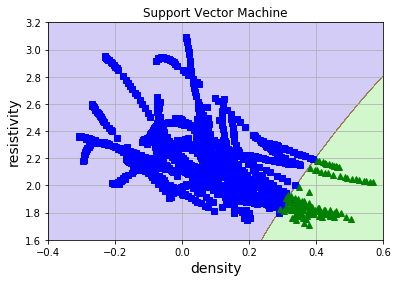

In [16]:
plot_dataset(X_train, y_train, [-0.4, 0.6, 1.6, 3.2])
plot_predictions(svm_clf, [-0.4, 0.6, 1.6, 3.2])
plt.title('Support Vector Machine')

트리 기반 모델들(결정 트리, 랜덤 포레스트, 그레디언트 부스팅)은 특성에 수직하게 데이터를 분리하는 성질을 가지므로 계단 형태의 결정 경계를 보이는 것을 알 수 있고, 데이터가 존재하지 않는 부분에서는 선형적으로 데이터를 분리하므로, 만약 새로운 데이터가 기존 데이터 범위 바깥에 존재한다면 잘못된 예측을 출력할 위험성이 있다. 아래의 테스트 데이터의 경우가 그러하다.

로지스틱 회귀와 서포트 벡터 머신은 유사한 결정 경계를 보인다. 단 서포트 벡터 머신이 검증 정확도가 조금 더 높기 때문에 서포트 벡터 머신을 최종 모델로 선정한다.

# 테스트 데이터 예측

최종으로 결정된 서포트 벡터 머신 모델을 이용하여 테스트 데이터에 적용하였다. 

In [18]:
test_data = pd.read_csv('Data/properties_data.csv')
X_test = test_data[['density', 'resistivity']].values

In [19]:
y_pred_test = svm_clf.predict(X_test)

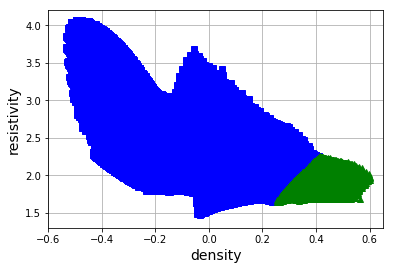

In [20]:
plot_dataset(X_test, y_pred_test, [-0.6, 0.65, 1.3, 4.2])